# Overview

This is a Jupyter notebook (work in progress) to visualize the data gathered during our testing with the SATURN patch.

The basic data filtering approach will be as follows:

For each dataset containing a time series of voltage readings:
1. Trim the dataset's beginning and end for "dead zones" where there is no data.
2. Smooth the dataset by taking the moving average.
3. Split the dataset into individual segments, since one dataset typically contains 5 individual readings of 1 gesture.
    
Then the data can be visualized. We're trying a few different approaches:
* [All Data](#All-Data) contains a list of the raw waveforms for all datasets. Useful for debugging.
* [All Data, Sliced and Overlaid](#All-Data--Sliced-and-Overlaid) contains a chart for each waveform containing all the segments, adjusted to be the same length and overlaid upon each other. Useful for validating that input data is consistent.
* [Segments by Gesture](#Segments-by-Gesture) contains a chart for each gesture. In each gesture chart, the segmented data from each configuration of SATURN (ex. with backing material, without backing material, large pad, small pad, etc.) is overlaid. This will help us determine what SATURN configurations produce the most differentiable signals.

# Imports and Utility Functions

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import itertools
import os
from numpy.fft import fft, fftfreq, ifft, rfft

# Returns a list of the datasets in the data directory.
# Each dataset in this list is a dict with three attributes:
#   Dir: directory under data/ occupied by this dataset
#   File: filename without extension
#   Path: relative path to .csv
def get_available_datasets():
    data = []

    for datafile in filter(lambda x: x[-4:] == '.csv',
        list(itertools.chain(*[[root+'/'+file for file in files]
        for root, _, files in os.walk('./data')]))):
        
        n = datafile.split('/')
        data.append({
            'Dir': n[-2],
            'File': n[-1].split('.')[0],
            'Path': datafile
        })

    return data

# Returns a dataset's contents as a list.
# If `raw` is not set, the results will be filtered and normalized.
def load_dataset(datum, raw=False):
    if 'Dataset' in datum and raw == datum['DatasetRaw']:
        return datum['Dataset']
    dataset = pd.read_csv(datum['Path'], names=['V'], header=None)
    dataset = list(dataset['V'])
    if not raw:  # normalize and filter the data
        dataset = normalize_dataset(dataset)
        #dataset = trim_dataset(dataset)
        #dataset = moving_average(dataset, 20)
        #dataset = segment_dataset(dataset, threshold=0.01, min_spacing=100)
    datum['Dataset'] = dataset
    datum['DatasetRaw'] = raw
    return dataset

# Normalize a dataset by dividing by max amplitude.
def normalize_dataset(data):
    return np.divide(data, np.max(data))

# Removes all leading and trailing points that fall under a certain threshold.
# The idea is to remove the irrelevant start and end portions of our data.
# Returns the relevant slice.
def trim_dataset(data, threshold=0.01):
    i = 0
    while abs(data[i]) < threshold and i < len(data):
        i += 1
    j = len(data) - 1
    while abs(data[j]) < threshold and j > i:
        j -= 1
    return data[i:j]

# Returns a list of the contiguous segments of the dataset.
# A contiguous segment is defined as some slice separated by at least 
# `min_spacing` points where the signal is less than `threshold` from 
# the next segment.
# Returns a list of lists (segments)
def segment_dataset(data, threshold=0.01, min_spacing=100):
    i = 0
    spaces = 0
    intervals = []
    start = None
    while i < len(data):
        while abs(data[i]) < threshold and i < len(data): 
            i += 1
        start = i
        spaces = 0
        end = i
        while i < len(data):
            if abs(data[i]) < threshold:
                spaces += 1
            else:
                spaces = 0
                end = i
            if spaces > min_spacing:
                intervals.append((start, end))
                start = None
                end = None
    if start and not end:
        intervals.append((start, i))
    print(intervals)
    return [data[interval[0]:interval[1]] for interval in intervals]

# Given a `data` as a list and a `window_size` number, it will return
# `data` with each point averaged with the previous `window_size` points.
def moving_average(data, window_size):
    res = []
    for (i,t) in enumerate(data):
        if i == 0:
            continue
        start = i - window_size
        if start < 0:
            start = 0
        end = i
        sl = data[start:end]
        x = np.average(sl)
        res.append(x)
    return res

data = get_available_datasets()

plt.rcParams["figure.figsize"] = (40,16)  # change size of charts
plt.rcParams["figure.max_open_warning"] = 0

# All Data

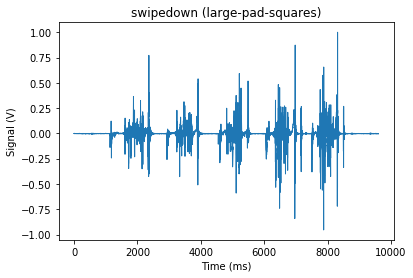

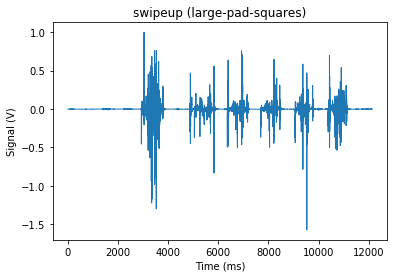

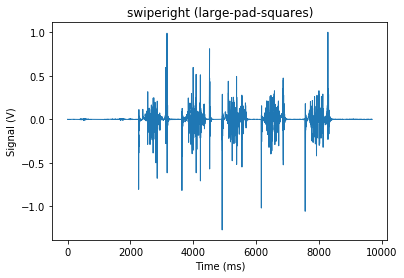

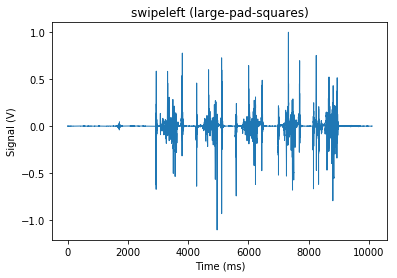

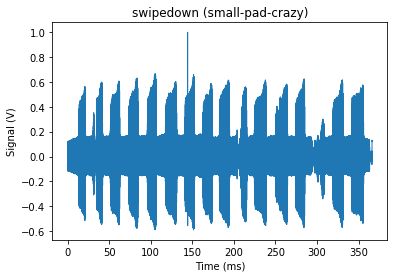

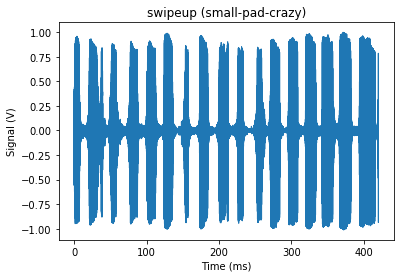

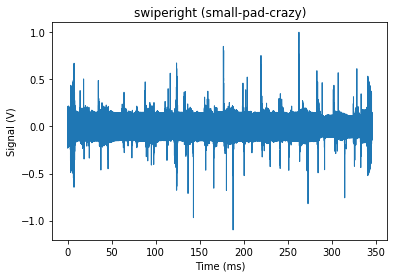

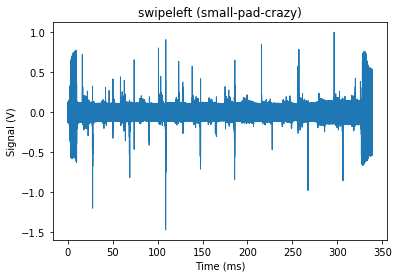

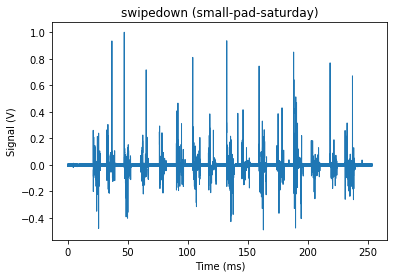

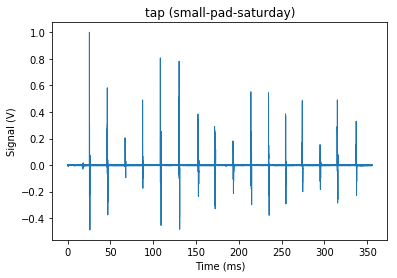

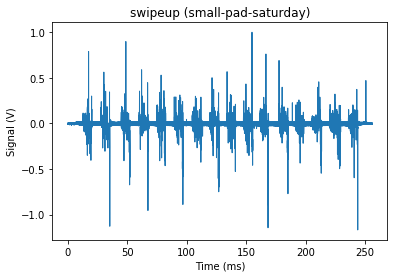

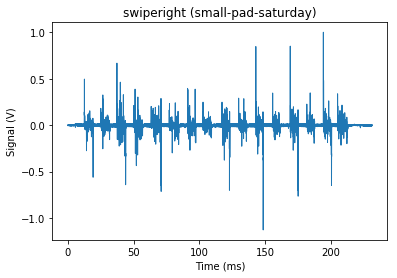

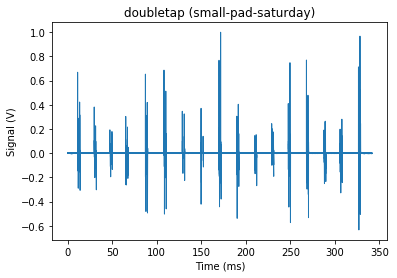

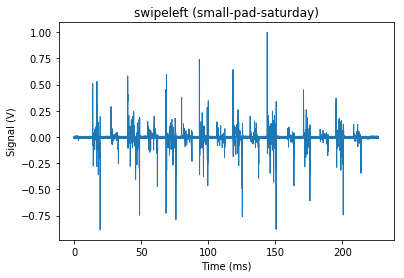

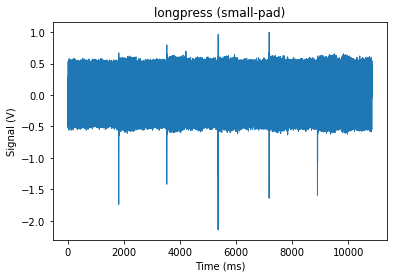

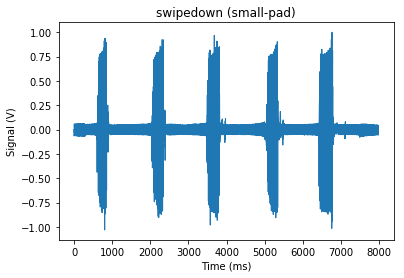

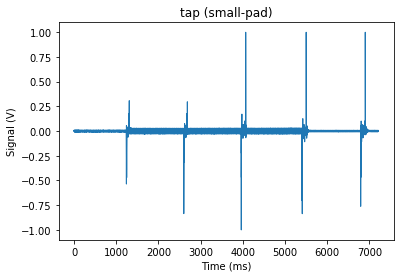

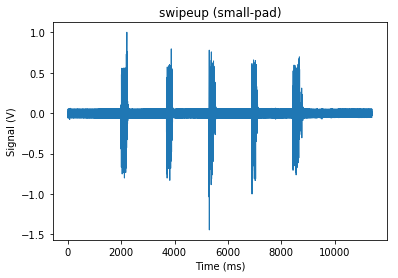

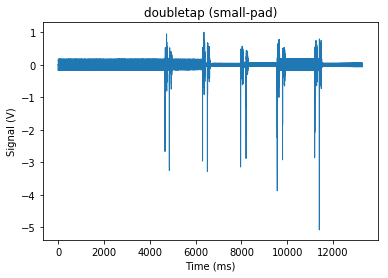

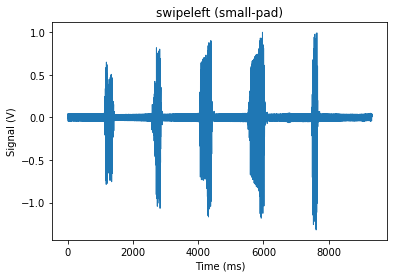

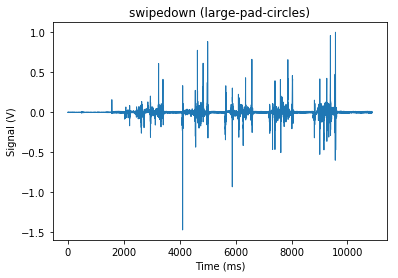

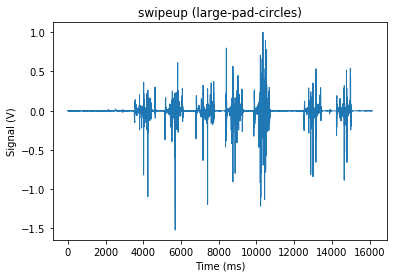

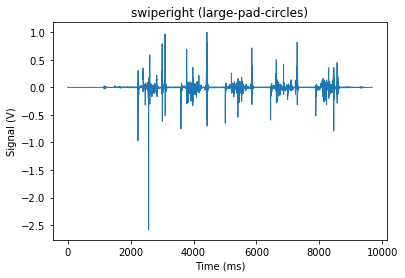

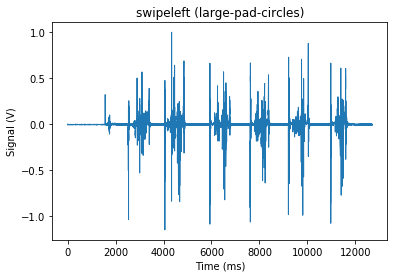

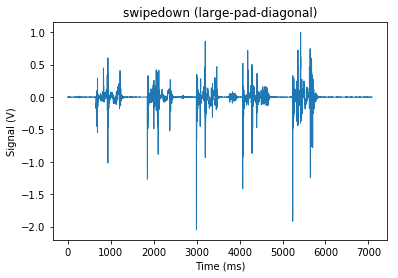

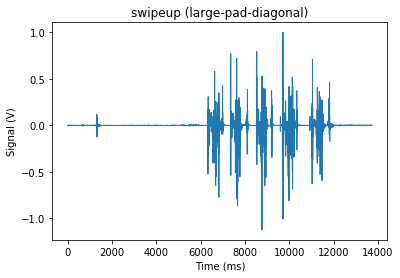

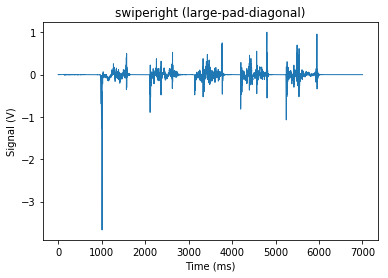

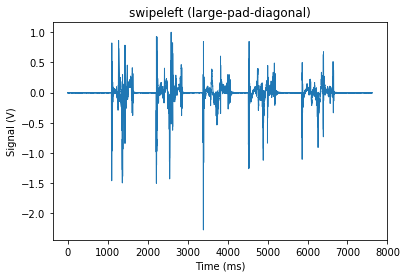

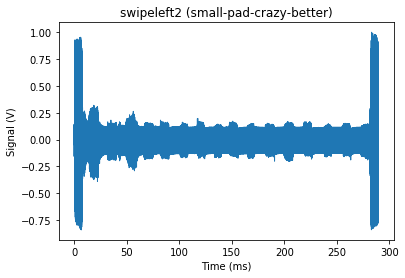

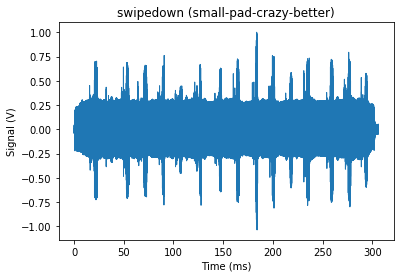

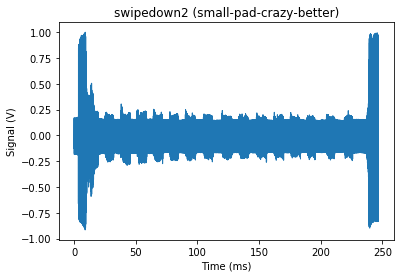

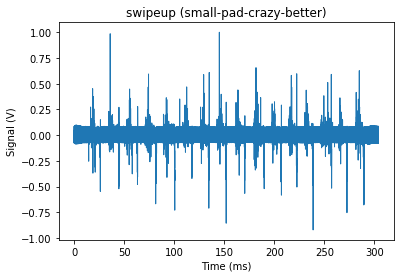

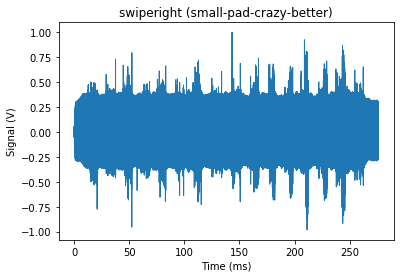

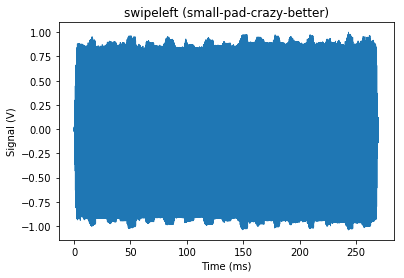

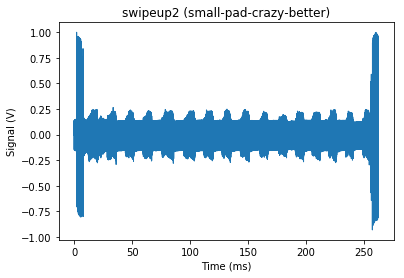

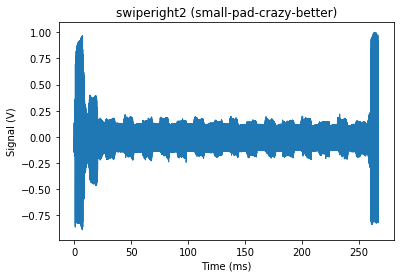

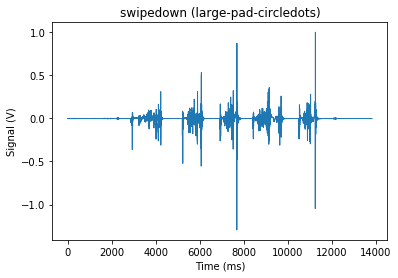

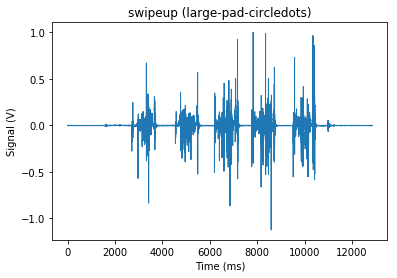

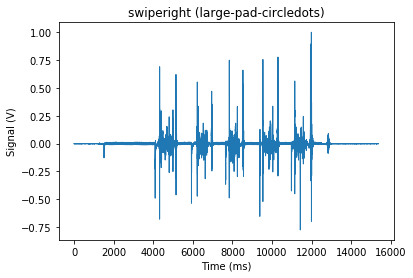

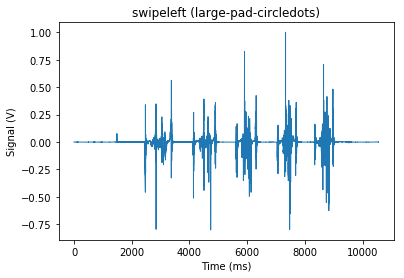

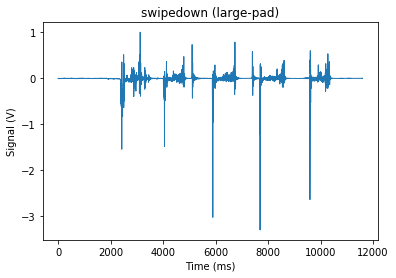

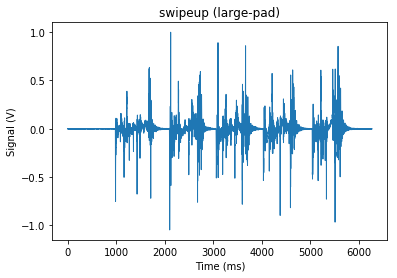

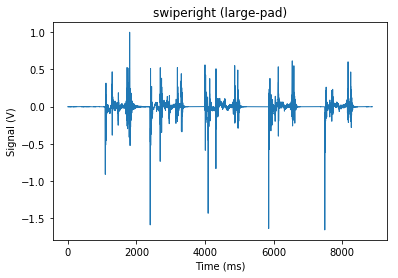

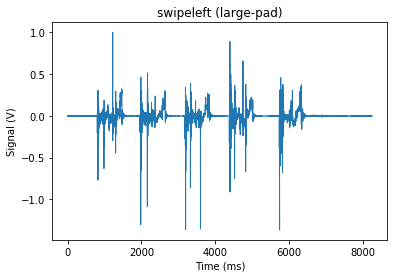

In [4]:
for (i, datum) in enumerate(data):
    df = load_dataset(datum)
    plt.figure(i)
    plt.ylabel('Signal (V)')
    plt.xlabel('Time (ms)')
    w = plt.plot([float(i)*(float(1)/50) for i in range(0, len(df))], df, linewidth=1.0)
    plt.title(datum['File'] + ' (' + datum['Dir'] + ')')

# Waveforms by Gesture

In [ ]:
g = {}
for (i, datum) in enumerate(data):
    if datum['File'] not in g:
        g[datum['File']] = []
    g[datum['File']].append(datum)
for (i, gesture) in enumerate(g.keys()):
    gdata = g[gesture]
    plt.figure(i)
    plt.ylabel('Signal (V)')
    plt.xlabel('Time (ms)')
    for datum in gdata:
        df = load_dataset(datum)
        w = plt.plot([float(i)*(float(1)/50) for i in range(0, len(df))], df, linewidth=1.0, label=datum['Dir'])
    plt.title('All ' + gesture + ' Gestures')

# Segmentation (finding Gestures)

In [3]:
def find_gestures_in_all_datasets(path_filter="", sample_win_size=50000, overlap=.5, threshold=45000):
    datasets_dict = get_available_datasets()
    map_dataname_to_gestures_indices_list = {}
    
    for (i, datum) in enumerate(datasets_dict):
        if path_filter not in datum['Path']:
            continue
        #print('____', datum['Path'])
        dataset = load_dataset(datum, raw=True)
        gestures = find_gestures_in_dataset(dataset, sample_win_size=sample_win_size, threshold=threshold, overlap=overlap)
        yield (datum, gestures)
    return
      
# little test function to empiracally determine the best sample_win_size and threshold for dataset
# yields best gesture approximation, assuming 16 gestures per sample dataset
def find_gestures_in_new_small_pad_datasets(path_filter="small-pad-"):
    #500Hz
    datasets_dict = get_available_datasets()
    map_dataname_to_gestures_indices_list = {}
    
    for (i, datum) in enumerate(datasets_dict):
        if path_filter not in datum['Path']:
            continue
        print('____', datum['Path'])
        dataset = load_dataset(datum, raw=True)
        best_gestures = []
        best_threshold = 0
        target_gestures = 16
        best_win_size = 0
        for sample_win_size in np.linspace(250, 250, num=1):
            sample_win_size = int(sample_win_size)
            for threshold in np.linspace(12, 15, num=3):
                gestures = find_gestures_in_dataset(dataset, sample_win_size=sample_win_size, threshold=threshold)
                if abs(len(gestures) - target_gestures) < abs(len(best_gestures) - target_gestures) or len(best_gestures) == 0:
                    best_gestures = gestures
                    best_threshold = threshold
                    best_win_size = sample_win_size
        print("Best threshold for " + datum['Path'] + ": " + str(best_threshold) + " and win_size=" + str(best_win_size) + " with " + str(len(best_gestures)) + " gestures")
        map_dataname_to_gestures_indices_list[datum['Path']] = best_gestures
        yield (datum, best_gestures)
    return

# returns the list of gesture events happening in dataset
# cur_dataset: a list of readings
def find_gestures_in_dataset(cur_dataset, sample_win_size=50000, overlap=.5, threshold=45000):
    total_time_range = len(cur_dataset)/sample_win_size

    sample_win_size = round(sample_win_size)
    start_win = 0
    end_win = sample_win_size
    slide_amount = round(sample_win_size * overlap)

    map_start_to_fft_sum = {}
    signals_list = []

    # list of sums of all fft bin for each window used on this dataset 
    # each window represents one second of the signal
    list_of_fftSums = []
    
    while start_win < len(cur_dataset):
        # each window covers an event occuring in one second of time
        window_data = cur_dataset[start_win:end_win]
        
        # getting sum of fft bins, then the sum of their frequency values
        fft_vals = rfft(window_data)

        sum_of_fftValues = sum(np.abs(fft_vals))

        # scale smaller slices - no idea if this is accurate
        sum_of_fftValues *= np.round(sample_win_size / (end_win - start_win))

        # appending sum of the fftbins to list 
        list_of_fftSums += [sum_of_fftValues]
        #print(sum_of_fftValues)
        
        # update the window size to include 50000 samples, half new and half old.
        start_win += slide_amount
        end_win = min(end_win + slide_amount, len(cur_dataset))

        #print(sum_of_fftValues)
    fftSums = list_of_fftSums
    i = 0
    gestures = []
    while i < len(fftSums):
        if fftSums[i] > threshold:
            start = i
            while i < len(fftSums) and fftSums[i] > threshold:
                i += 1
            end = i
            gestures += [(slide_amount*start, slide_amount*end)]
        i += 1
           
    # refine start and end points of gesture
    for (i, gesture) in enumerate(gestures):
        squared_gesture = np.power(cur_dataset[gesture[0]:gesture[1]], 2)
        percentile = np.percentile(squared_gesture, 60)
        start = 0
        while squared_gesture[start] > percentile:
            start += 1
        end = len(squared_gesture) - 1
        while squared_gesture[end] < percentile:
            end -= 1
        gestures[i] = (gesture[0] + start, gesture[0] + end)
        
    
    gestures = filter(lambda g: g[1] - g[0] > sample_win_size / 2, gestures)
    gestures = filter(lambda g: g[1] - g[0] < sample_win_size * 5, gestures)
    gestures = list(gestures)
    
    return gestures

# Classification (which gesture?) 

In [10]:
from sklearn.neighbors import KNeighborsClassifier

# print(list(find_gestures_in_new_small_pad_datasets(path_filter="small-pad-saturday")))

# empiracally determined that win size of 1/2 second and threshold 12 works decently for finding gestures
all_gestures = list(find_gestures_in_all_datasets(path_filter="small-pad-saturday", sample_win_size=250, overlap=.5, threshold=12))

# build knn model
# mapping: dict of gesture_name -> [sample gestures] mappings
def build_knn_model(mapping):
    knn = KNeighborsClassifier(n_neighbors=3)
    X = []
    y = []
    for gesture_name, sample_gestures in mapping.items():
        for sample_gesture in sample_gestures:
            normalized = np.interp(np.linspace(0, len(sample_gesture)-1, num=500), range(0, len(sample_gesture)), sample_gesture)
            X.append(normalized)
            y.append([gesture_name])
    return (X, y, knn.fit(X, y))

mapping = {datum['File']: [load_dataset(datum, raw=False)[g[0]:g[1]] for g in gestures] for (datum, gestures) in all_gestures}
X, y, knn = build_knn_model(mapping)

for (i, normalized) in enumerate(X):
    gesture_name = y[i][0]
    prediction = knn.predict([normalized])
    success = prediction[0] == gesture_name
    print("%s\t%s\t%s" % (gesture_name, prediction[0], success))
    print()
    

swipedown	doubletap	False

swipedown	doubletap	False

swipedown	swipedown	True

swipedown	doubletap	False

swipedown	swipedown	True

swipedown	doubletap	False

swipedown	doubletap	False

swipedown	swipedown	True

swipedown	swipedown	True

swipedown	swipedown	True

swipedown	doubletap	False

swipedown	doubletap	False

swipedown	swipeleft	False

swipedown	tap	False

swipedown	tap	False

swipedown	doubletap	False

tap	tap	True

tap	tap	True

tap	tap	True

tap	tap	True

tap	tap	True

tap	tap	True

tap	tap	True

tap	tap	True

tap	tap	True

tap	tap	True

tap	tap	True

tap	tap	True

tap	tap	True

tap	tap	True

tap	tap	True

tap	tap	True

swipeup	swipeleft	False

swipeup	swipeup	True

swipeup	swipeleft	False

swipeup	swiperight	False

swipeup	swipeleft	False

swipeup	swipeup	True

swipeup	doubletap	False

swipeup	doubletap	False

swipeup	swipeleft	False

swipeup	tap	False

swipeup	swipeup	True

swipeup	swipeleft	False

swipeup	tap	False

swipeup	swipedown	False

swipeup	swipedown	False

swipeu

/home/zach/.config/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
